In [323]:
from distutils.core import setup
import py2exe

setup(console=['main.py'])

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.fft import fft as fft

In [324]:
class String:
    def __init__(self, N=0, L=0, e=0, b=0, c=0):
        self.N = N;
        self.L = L;
        self.e = e;
        self.c = c;
        self.b = b;
        self.a = np.zeros(N+1)
        self.v = np.zeros(N+1)
        self.y = np.zeros(N+1)
        self.x = np.linspace(0, L, N+1)
        
    def copy(self):
        s_copy = String() 
        s_copy.N = self.N 
        s_copy.L = self.L 
        s_copy.e = self.e 
        s_copy.c = self.c 
        s_copy.b = self.b 
        s_copy.a = self.a 
        s_copy.v = self.v 
        s_copy.y = self.y 
        s_copy.x = self.x 
        return s_copy
    
    def find_a(self, B):
        N = self.N
        for n in range(1, N):
            ypp = self.y[n-1] - 2*self.y[n] + self.y[n+1]
            vpp = self.v[n-1] - 2*self.v[n] + self.v[n+1]
            if n == 1:
                ypppp = -4*self.y[0] + 6*self.y[1] - 4*self.y[2] + self.y[3]
            elif n==N-1:
                ypppp = self.y[N-3] - 4*self.y[N-2] + 6*self.y[N-1] -4*self.y[N]
            else:
                ypppp = self.y[n-2] - 4*self.y[n-1] + 6*self.y[n] -4*self.y[n+1] + self.y[n+2]
            self.a[n]= self.c*self.c * ypp - self.e * ypppp + B * vpp
        return self.a
        
    def pluck_relaxation(self, position, displacement):
        k1 = displacement / position
        k2 = displacement / (self.N - position)
        for n in range(1, position + 1):
            self.y[n] = k1 * n
        for n in range(position+1, self.N + 1):
            self.y[n] = k2 * (self.N - n)
        
        for n in range(5000):
            self.find_a(0)
            for n in range(self.N+1):    
                self.y[n] += self.a[n] * 0.003 * 0.003 / 2
            self.y[position] = displacement
    
    def savek_step(self, temp, dt, kv, ky):
        kv = temp.find_a(temp.b)
        ky = temp.v
        temp.v = self.v + dt * self.a
        temp.y = self.y + dt * self.v                                                                                                        
        return temp, kv, ky
    
    def rk4_step_by_dt(self, dt):
        kv = np.zeros((4, self.N+1), dtype=int)
        ky = np.zeros((4, self.N+1), dtype=int)

        s_tmp = self.copy() #s-tmp is the temporary stringstatus after each step
        s_tmp, kv[0], ky[0] = self.savek_step(s_tmp, dt/2, kv[0], ky[0])
        s_tmp, kv[1], ky[1] = self.savek_step(s_tmp, dt/2, kv[1], ky[1])
        s_tmp, kv[2], ky[2] = self.savek_step(s_tmp, dt/2, kv[2], ky[2])
        s_tmp, kv[3], ky[3] = self.savek_step(s_tmp, dt  , kv[3], ky[3])
        self.v = self.v + dt * (kv[0] + 2*kv[1] + 2*kv[2] + kv[3]) / 6
        self.y = self.y + dt * (ky[0] + 2*ky[1] + 2*ky[2] + ky[3]) / 6
        # print(s_tmp.a, kv, ky)
        return self
               
    def evolve_with_time(self, Tmax, dt):
        t = 0
        while(t<Tmax):
            self.rk4_step_by_dt(dt)
            t += dt
        return self
    
    def FFT(self):
        fft_data = fft(self.y)
        return fft_data
    
    def normalize(self):
        mag2 = 0
        for y in self.y:
            mag2 += math.pow(y, 2)
        mag = math.pow(mag2, 0.5)
        self.y /= mag
        return self.y
    
    def pic(self):
        plt.scatter(self.x, self.y)
      

In [325]:
def vector_mag(y_arr):
    mag2 = 0
    for y in y_arr:
        mag2 += math.pow(y, 2)
    mag = math.pow(mag2, 0.5)
    return mag

0 0
1 10
2 20
3 30
4 40
5 50
6 60
7 70
8 80
9 90


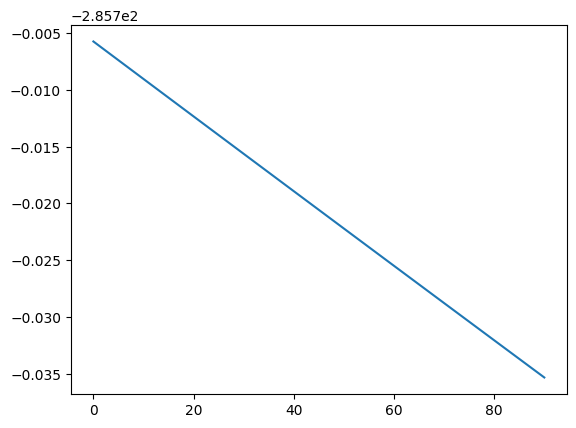

In [326]:
e, de, e_max = 0, 10, 100 
e_arr = np.arange(e, e_max, de)
lam = np.zeros( len(e_arr), dtype=float)
i = 0
while(e < e_max-0.001):
    s1 = String(63, 1.5, e, 500, 250)
    s2 = String(63, 1.5, e, 500, 250)
    
    s1.pluck_relaxation(20, 0.05)
    s1.normalize()
    s2.pluck_relaxation(21, 0.05)
    s2.normalize()
    d_Fn_0 = s1.y - s2.y
    
    T = 0.01
    s1.evolve_with_time(T, 0.01)
    s2.evolve_with_time(T, 0.01)
    d_Fn_T = s1.y - s2.y
    
    mag_0 = vector_mag(d_Fn_0)
    mag_T = vector_mag(d_Fn_T)
    lam[i] = 1 / T * (math.log(mag_0) - math.log(mag_T)) 
    
    print(i, e)
    i = i + 1
    e = e + de
    

plt.plot(e_arr, lam)   


AttributeError: 'String' object has no attribute 'evolve_rk4'

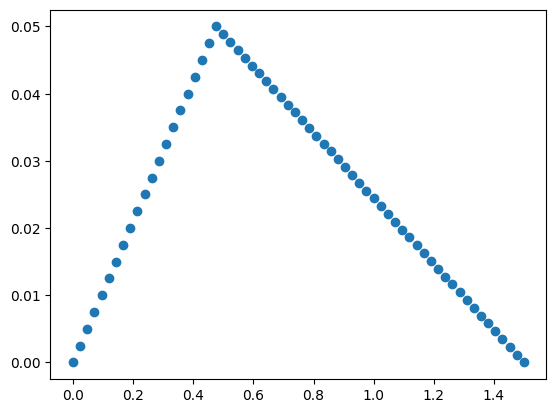

In [327]:
s1 = String(63, 1.5, 10, 500, 250)
s1.pluck_relaxation(20, 0.05)
s1.pic()
s1.evolve_rk4(0.01)
s1.pic()